# Master run

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import xagg as xa
import pandas as pd
import re
from tqdm.notebook import tqdm as tqdm


from wrapper_funcs import (wrapper_bin_dmgf,wrapper_proj,wrapper_dyield,wrapper_var_partitioning,
                           wrapper_figure_s4,wrapper_figure_s5,wrapper_dT_bymonth_maps,wrapper_exposure_distributions)
from plot_funcs import (figure_part_uncert,plot_hist_bauble,fig_geo_partition,
                        figure_partitioned_uncert_panel_bysource,figure_bauble_panel)
from plot_funcs_main import (wrapper_figure1,wrapper_figure2,wrapper_figure3,wrapper_figure4)

from proc_funcs import (calc_dtas,calc_dtas_bymonth)

from aux_funcs import get_params,generate_weightmaps,check_dirs

## Setup


In [2]:
# Get directory paths
dir_list = get_params()

In [3]:
master_params = {'obs_mod':'ERA-INTERIM',                               # The name of the observational data product
                 'obs_search_str':'tas_day_ERA-INTERIM.*CUSA\.nc',      # To identify raw observation data to process
                 'obs_data_dir':dir_list['obs'],                        # For raw observation data
                 'mod_data_dir':dir_list['mod'],                        # For raw model data
                 'mod_search_str':'^.*tas\_Amon.*hist\-rcp85.*\.nc$',   # To identify raw climate data to process
                 'proc_data_dir':dir_list['proc'],                      # For projected climate data
                 'impact_data_dir':dir_list['impact'],                  # For projected impact variables 
                 'aux_data_dir':dir_list['aux'],                        # For auxiliary files generated by county aggregation
                 'exp_name':'rcp85',                                    # The Large Ensemble scenario name
                 'overwrite':False,                                     # Whether to overwrite existing files
                 'varname':'tas'}                                       # The raw variable name

In [4]:
# The start and end dates of the different time segments 
# (with "hist" being used as the reference time period, with
# changes given for each of the other timeframes vs. "hist") 
subset_params = {'hist':('19800101','20091231'),
                 'begc':('20100101','20391231'),
                 'midc':('20400101','20691231'),
                 'endc':('20700101','20991231')}

In [5]:
dmgf = xr.DataArray([0.69,0.59,0.64,0.36,0.27,0,0.12,0.23,0.33,0.94],dims=['bin'],coords=[np.arange(1,11)])
bins_dng = np.append(np.append(-np.inf,(np.arange(10,91,10)+459.67)*5/9),np.inf)
bin_name_dng = '_dng'

# This was total county income, Table 3. Wanted Table 2 instead
#dmgf_dnh = xr.DataArray([6.55,4.28,-1.73,-5.74,-10.61,-5.47,-3.12,-2.47,-1.07,-1.00,0,-2.77,-7.46,-6.92,-14.78,-16.71,-20.56],
#                          dims=['bin'],coords=[np.arange(1,18)])

# This is from table 2: "The effect of daily temperature on log total annual income per capita"
dmgf_dnh = xr.DataArray([0.000234,0.000126,-0.000144,-0.000269,-0.000322,-0.000195,-0.000119,-0.000074,-0.000003,-0.000036,
                         0,-0.000111,-0.000311,-0.000294,-0.000585,-0.000646,-0.000757],
                           dims=['bin'],coords=[np.arange(1,18)])
bins_dnh = np.append(np.append(-np.inf,np.arange(-15,31,3)+273.15),np.inf)
bin_name_dnh = '_dnh'

In [6]:
# Search strings for the model data

# Alternate just for CMIP5 models (no "LE")
#file_params = {'rcp85':'^.*tas\_Amon((?!LE).)*hist\-rcp85.*\.nc$',
#               'rcp60':'^.*tas\_Amon((?!LE).)*hist\-rcp60.*\.nc$',
#               'rcp45':'^.*tas\_Amon((?!LE).)*hist\-rcp45.*\.nc$',
#               'rcp26':'^.*tas\_Amon((?!LE).)*hist\-rcp26.*\.nc$'} 

# Alternate just for LE 
#file_params = {'rcp85':'^.*tas\_Amon.*\-LE.*hist\-rcp85.*\.nc$'}


file_params = {'rcp85':'^.*tas\_Amon((?!ERA5).)*hist\-rcp85.*\.nc$',
               'rcp60':'^.*tas\_Amon((?!LE|ERA5).)*hist\-rcp60.*\.nc$',
               'rcp45':'^.*tas\_Amon((?!LE|ERA5).)*hist\-rcp45.*\.nc$',
               'rcp26':'^.*tas\_Amon((?!LE|ERA5).)*hist\-rcp26.*\.nc$'} 



## Verify directory structure

In [7]:
check_dirs(master_params)

+ model directory: /dx01/kschwarz/climate_raw/ exists; contains data from 21 models and data products in total!
+ observation directory: /dx01/kschwarz/climate_raw/ERA-INTERIM exists, contains at least one file that matches tas_day_ERA-INTERIM.*CUSA\.nc.
+ geo directory: county-level data found at /dx01/kschwarz/impact_uncert/geo_data/UScounties_proc.shp
+ aux directory: /dx01/kschwarz/impact_uncert/aux_data/ exists!
+ figs directory: /home/kschwarz/projects/iv_impacts/figures/ exists!
+ proc directory: /dx01/kschwarz/climate_proc/ERA-INTERIM/ exists!
+ impact directory: /dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/ exists!


## Generate weightmaps for future processing
(optional, may speed up processing slightly)

In [8]:
#generate_weightmaps(master_params)

## Create projections

In [9]:
for exp in file_params:
    master_params['mod_search_str'] = file_params[exp]
    master_params['exp_name'] = exp
    out_data = wrapper_proj(master_params,subset_params,save_output=True,return_output=False,exp_name=master_params['exp_name'])

  0%|          | 0/21 [00:00<?, ?it/s]

/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_historical_CESM1-CAM5-LEgrid_19800101-20091231_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_rcp85_CESM1-CAM5-LEproj_20100101-20391231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_rcp85_CESM1-CAM5-LEproj_20400101-20691231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_rcp85_CESM1-CAM5-LEproj_20700101-20991231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_historical_CSIRO-Mk3-6-0grid_19800101-20091231_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_rcp85_CSIRO-Mk3-6-0proj_20100101-20391231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_rcp85_CSIRO-Mk3-6-0proj_20400101-20691231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_rcp

  0%|          | 0/14 [00:00<?, ?it/s]

/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_historical_CSIRO-Mk3-6-0grid_19800101-20091231_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_rcp60_CSIRO-Mk3-6-0proj_20100101-20391231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_rcp60_CSIRO-Mk3-6-0proj_20400101-20691231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_rcp60_CSIRO-Mk3-6-0proj_20700101-20991231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_historical_GFDL-CM3grid_19800101-20091231_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_rcp60_GFDL-CM3proj_20100101-20391231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_rcp60_GFDL-CM3proj_20400101-20691231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_rcp60_GFDL-CM3proj

  0%|          | 0/14 [00:00<?, ?it/s]

/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_historical_CSIRO-Mk3-6-0grid_19800101-20091231_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_rcp45_CSIRO-Mk3-6-0proj_20100101-20391231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_rcp45_CSIRO-Mk3-6-0proj_20400101-20691231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_rcp45_CSIRO-Mk3-6-0proj_20700101-20991231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_historical_GFDL-CM3grid_19800101-20091231_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_rcp45_GFDL-CM3proj_20100101-20391231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_rcp45_GFDL-CM3proj_20400101-20691231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_rcp45_GFDL-CM3proj

  0%|          | 0/14 [00:00<?, ?it/s]

/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_historical_CSIRO-Mk3-6-0grid_19800101-20091231_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_rcp26_CSIRO-Mk3-6-0proj_20100101-20391231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_rcp26_CSIRO-Mk3-6-0proj_20400101-20691231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_rcp26_CSIRO-Mk3-6-0proj_20700101-20991231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_historical_GFDL-CM3grid_19800101-20091231_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_rcp26_GFDL-CM3proj_20100101-20391231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_rcp26_GFDL-CM3proj_20400101-20691231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tas_day_ERA-INTERIM_rcp26_GFDL-CM3proj

In [10]:
for varname in ['tasmin','tasmax']:
    master_params_tmp = {k:v for k,v in master_params.items() if k not in['obs_search_str']}
    master_params_tmp['obs_search_str'] = re.sub('tas',varname,master_params['obs_search_str'])
    
    for exp in tqdm(file_params):
        master_params_tmp['mod_search_str'] = file_params[exp]
        master_params_tmp['exp_name'] = exp
        out_data = wrapper_proj(master_params_tmp,subset_params,save_output=True,return_output=False,exp_name=master_params_tmp['exp_name'])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_historical_CESM1-CAM5-LEgrid_19800101-20091231_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_rcp85_CESM1-CAM5-LEproj_20100101-20391231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_rcp85_CESM1-CAM5-LEproj_20400101-20691231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_rcp85_CESM1-CAM5-LEproj_20700101-20991231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_historical_CSIRO-Mk3-6-0grid_19800101-20091231_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_rcp85_CSIRO-Mk3-6-0proj_20100101-20391231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_rcp85_CSIRO-Mk3-6-0proj_20400101-20691231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/ta

  0%|          | 0/14 [00:00<?, ?it/s]

/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_historical_CSIRO-Mk3-6-0grid_19800101-20091231_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_rcp60_CSIRO-Mk3-6-0proj_20100101-20391231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_rcp60_CSIRO-Mk3-6-0proj_20400101-20691231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_rcp60_CSIRO-Mk3-6-0proj_20700101-20991231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_historical_GFDL-CM3grid_19800101-20091231_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_rcp60_GFDL-CM3proj_20100101-20391231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_rcp60_GFDL-CM3proj_20400101-20691231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-IN

  0%|          | 0/14 [00:00<?, ?it/s]

/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_historical_CSIRO-Mk3-6-0grid_19800101-20091231_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_rcp45_CSIRO-Mk3-6-0proj_20100101-20391231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_rcp45_CSIRO-Mk3-6-0proj_20400101-20691231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_rcp45_CSIRO-Mk3-6-0proj_20700101-20991231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_historical_GFDL-CM3grid_19800101-20091231_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_rcp45_GFDL-CM3proj_20100101-20391231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_rcp45_GFDL-CM3proj_20400101-20691231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-IN

  0%|          | 0/14 [00:00<?, ?it/s]

/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_historical_CSIRO-Mk3-6-0grid_19800101-20091231_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_rcp26_CSIRO-Mk3-6-0proj_20100101-20391231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_rcp26_CSIRO-Mk3-6-0proj_20400101-20691231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_rcp26_CSIRO-Mk3-6-0proj_20700101-20991231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_historical_GFDL-CM3grid_19800101-20091231_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_rcp26_GFDL-CM3proj_20100101-20391231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-INTERIM_rcp26_GFDL-CM3proj_20400101-20691231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmin_day_ERA-IN

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_historical_CESM1-CAM5-LEgrid_19800101-20091231_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_rcp85_CESM1-CAM5-LEproj_20100101-20391231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_rcp85_CESM1-CAM5-LEproj_20400101-20691231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_rcp85_CESM1-CAM5-LEproj_20700101-20991231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_historical_CSIRO-Mk3-6-0grid_19800101-20091231_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_rcp85_CSIRO-Mk3-6-0proj_20100101-20391231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_rcp85_CSIRO-Mk3-6-0proj_20400101-20691231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/ta

  0%|          | 0/14 [00:00<?, ?it/s]

/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_historical_CSIRO-Mk3-6-0grid_19800101-20091231_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_rcp60_CSIRO-Mk3-6-0proj_20100101-20391231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_rcp60_CSIRO-Mk3-6-0proj_20400101-20691231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_rcp60_CSIRO-Mk3-6-0proj_20700101-20991231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_historical_GFDL-CM3grid_19800101-20091231_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_rcp60_GFDL-CM3proj_20100101-20391231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_rcp60_GFDL-CM3proj_20400101-20691231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-IN

  0%|          | 0/14 [00:00<?, ?it/s]

/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_historical_CSIRO-Mk3-6-0grid_19800101-20091231_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_rcp45_CSIRO-Mk3-6-0proj_20100101-20391231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_rcp45_CSIRO-Mk3-6-0proj_20400101-20691231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_rcp45_CSIRO-Mk3-6-0proj_20700101-20991231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_historical_GFDL-CM3grid_19800101-20091231_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_rcp45_GFDL-CM3proj_20100101-20391231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_rcp45_GFDL-CM3proj_20400101-20691231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-IN

  0%|          | 0/14 [00:00<?, ?it/s]

/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_historical_CSIRO-Mk3-6-0grid_19800101-20091231_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_rcp26_CSIRO-Mk3-6-0proj_20100101-20391231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_rcp26_CSIRO-Mk3-6-0proj_20400101-20691231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_rcp26_CSIRO-Mk3-6-0proj_20700101-20991231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_historical_GFDL-CM3grid_19800101-20091231_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_rcp26_GFDL-CM3proj_20100101-20391231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-INTERIM_rcp26_GFDL-CM3proj_20400101-20691231_CUSA.nc already exists; skipped.
/dx01/kschwarz/climate_proc/ERA-INTERIM/tasmax_day_ERA-IN

## Heat - mortality 
(Deschênes and Greenstone)

In [8]:
# Load geographic data
data_counties = gpd.read_file(dir_list['geo']+'UScounties_proc.shp')

In [9]:
for exp in file_params:
    master_params_tmp = {k:v for k,v in master_params.items() if k not in['mod_search_str','exp_name']}
    master_params_tmp['mod_search_str'] = file_params[exp]
    master_params_tmp['exp_name'] = exp
    impact_ds = wrapper_bin_dmgf(master_params_tmp,subset_params,data_counties=data_counties,
                                 dmgf=dmgf,bins=bins_dng,
                                 bin_name=bin_name_dng,var_name='tpop',fn_prefix='dmort',
                                 description='heat-related mortality',dmgf_type='level')


---------------------------
Calculating bin-days
---------------------------

/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp85_CESM1-CAM5-LEproj_hist-begc-midc-endc_CUSA_dng.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp85_CSIRO-Mk3-6-0proj_hist-begc-midc-endc_CUSA_dng.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp85_CSIRO-Mk3-6-0-LEproj_hist-begc-midc-endc_CUSA_dng.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp85_CanESM2-LEproj_hist-begc-midc-endc_CUSA_dng.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp85_EC-EARTH-LEproj_hist-begc-midc-endc_CUSA_dng.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp85_GFDL-CM3proj_hist-begc-mid

0it [00:00, ?it/s]


---------------------------
Calculating bin-days
---------------------------

/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp60_CSIRO-Mk3-6-0proj_hist-begc-midc-endc_CUSA_dng.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp60_GFDL-CM3proj_hist-begc-midc-endc_CUSA_dng.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp60_GFDL-ESM2Gproj_hist-begc-midc-endc_CUSA_dng.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp60_GFDL-ESM2Mproj_hist-begc-midc-endc_CUSA_dng.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp60_GISS-E2-Hproj_hist-begc-midc-endc_CUSA_dng.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp60_GISS-E2-Rproj_hist-begc-midc-endc_CUSA_

0it [00:00, ?it/s]


---------------------------
Calculating bin-days
---------------------------

/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp45_CSIRO-Mk3-6-0proj_hist-begc-midc-endc_CUSA_dng.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp45_GFDL-CM3proj_hist-begc-midc-endc_CUSA_dng.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp45_GFDL-ESM2Gproj_hist-begc-midc-endc_CUSA_dng.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp45_GFDL-ESM2Mproj_hist-begc-midc-endc_CUSA_dng.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp45_GISS-E2-Hproj_hist-begc-midc-endc_CUSA_dng.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp45_GISS-E2-Rproj_hist-begc-midc-endc_CUSA_

0it [00:00, ?it/s]


---------------------------
Calculating bin-days
---------------------------

/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp26_CSIRO-Mk3-6-0proj_hist-begc-midc-endc_CUSA_dng.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp26_GFDL-CM3proj_hist-begc-midc-endc_CUSA_dng.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp26_GFDL-ESM2Gproj_hist-begc-midc-endc_CUSA_dng.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp26_GFDL-ESM2Mproj_hist-begc-midc-endc_CUSA_dng.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp26_GISS-E2-Hproj_hist-begc-midc-endc_CUSA_dng.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp26_GISS-E2-Rproj_hist-begc-midc-endc_CUSA_

0it [00:00, ?it/s]

## Heat - gdp 
(Deryugina and Hsiang)

In [13]:
for exp in file_params:
    master_params_tmp = {k:v for k,v in master_params.items() if k not in['mod_search_str','exp_name']}
    master_params_tmp['mod_search_str'] = file_params[exp]
    master_params_tmp['exp_name'] = exp
    impact_ds_dnh = wrapper_bin_dmgf(master_params_tmp,subset_params,data_counties=data_counties,
                                     dmgf=dmgf_dnh,bins = bins_dnh,
                                     bin_name=bin_name_dnh,var_name='gdp_pp',fn_prefix='dgdp-pp',
                                     description='per capita gdp',dmgf_type='log',
                                     op='mean',scale=1000)


---------------------------
Calculating bin-days
---------------------------

/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp85_CESM1-CAM5-LEproj_hist-begc-midc-endc_CUSA_dnh.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp85_CSIRO-Mk3-6-0proj_hist-begc-midc-endc_CUSA_dnh.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp85_CSIRO-Mk3-6-0-LEproj_hist-begc-midc-endc_CUSA_dnh.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp85_CanESM2-LEproj_hist-begc-midc-endc_CUSA_dnh.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp85_EC-EARTH-LEproj_hist-begc-midc-endc_CUSA_dnh.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp85_GFDL-CM3proj_hist-begc-mid

0it [00:00, ?it/s]


---------------------------
Calculating bin-days
---------------------------

/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp60_CSIRO-Mk3-6-0proj_hist-begc-midc-endc_CUSA_dnh.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp60_GFDL-CM3proj_hist-begc-midc-endc_CUSA_dnh.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp60_GFDL-ESM2Gproj_hist-begc-midc-endc_CUSA_dnh.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp60_GFDL-ESM2Mproj_hist-begc-midc-endc_CUSA_dnh.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp60_GISS-E2-Hproj_hist-begc-midc-endc_CUSA_dnh.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp60_GISS-E2-Rproj_hist-begc-midc-endc_CUSA_

0it [00:00, ?it/s]


---------------------------
Calculating bin-days
---------------------------

/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp45_CSIRO-Mk3-6-0proj_hist-begc-midc-endc_CUSA_dnh.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp45_GFDL-CM3proj_hist-begc-midc-endc_CUSA_dnh.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp45_GFDL-ESM2Gproj_hist-begc-midc-endc_CUSA_dnh.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp45_GFDL-ESM2Mproj_hist-begc-midc-endc_CUSA_dnh.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp45_GISS-E2-Hproj_hist-begc-midc-endc_CUSA_dnh.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp45_GISS-E2-Rproj_hist-begc-midc-endc_CUSA_

0it [00:00, ?it/s]


---------------------------
Calculating bin-days
---------------------------

/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp26_CSIRO-Mk3-6-0proj_hist-begc-midc-endc_CUSA_dnh.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp26_GFDL-CM3proj_hist-begc-midc-endc_CUSA_dnh.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp26_GFDL-ESM2Gproj_hist-begc-midc-endc_CUSA_dnh.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp26_GFDL-ESM2Mproj_hist-begc-midc-endc_CUSA_dnh.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp26_GISS-E2-Hproj_hist-begc-midc-endc_CUSA_dnh.nc already exists! Skipped.
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/tasbin_day_ERA-INTERIM_hist-rcp26_GISS-E2-Rproj_hist-begc-midc-endc_CUSA_

0it [00:00, ?it/s]

## Heat - corn yields
(Schlenker and Roberts)

In [14]:
#for exp in file_params:
for exp in ['rcp85']:
    master_params_tmp = {k:v for k,v in master_params.items() if k not in['mod_search_str','exp_name']}
    master_params_tmp['mod_search_str'] = file_params[exp]
    master_params_tmp['exp_name'] = exp
    
    wrapper_dyield(master_params_tmp,subset_params,
                       data_counties,process_by_lat_band=False)


---------------------------
Calculating damage function output
---------------------------



  0%|          | 0/21 [00:00<?, ?it/s]

/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/dyield_CESM1-CAM5-LE_rcp85_hist-begc-midc-endc_plinsum_CUSA.nc already exists, skipped!
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/dyield_CSIRO-Mk3-6-0_rcp85_hist-begc-midc-endc_plinsum_CUSA.nc already exists, skipped!
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/dyield_CSIRO-Mk3-6-0-LE_rcp85_hist-begc-midc-endc_plinsum_CUSA.nc already exists, skipped!
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/dyield_CanESM2-LE_rcp85_hist-begc-midc-endc_plinsum_CUSA.nc already exists, skipped!
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/dyield_EC-EARTH-LE_rcp85_hist-begc-midc-endc_plinsum_CUSA.nc already exists, skipped!
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/dyield_GFDL-CM3_rcp85_hist-begc-midc-endc_plinsum_CUSA.nc already exists, skipped!
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/dyield_GFDL-CM3-LE_rcp85_hist-begc-midc-endc_plinsum_CUSA.nc already exists, skipped!
/dx01/kschwarz/impact_

  0%|          | 0/21 [00:00<?, ?it/s]

/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/dyield_tot_CESM1-CAM5-LE_rcp85_hist-begc-midc-endc_bycounty_CUSA.nc removed to allow overwrite!
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/dyield_tot_CESM1-CAM5-LE_rcp85_hist-begc-midc-endc_bycounty_CUSA.nc saved!
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/dyield_tot_CSIRO-Mk3-6-0_rcp85_hist-begc-midc-endc_bycounty_CUSA.nc removed to allow overwrite!
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/dyield_tot_CSIRO-Mk3-6-0_rcp85_hist-begc-midc-endc_bycounty_CUSA.nc saved!
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/dyield_tot_CSIRO-Mk3-6-0-LE_rcp85_hist-begc-midc-endc_bycounty_CUSA.nc removed to allow overwrite!
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/dyield_tot_CSIRO-Mk3-6-0-LE_rcp85_hist-begc-midc-endc_bycounty_CUSA.nc saved!
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/dyield_tot_CanESM2-LE_rcp85_hist-begc-midc-endc_bycounty_CUSA.nc removed to allow overwrite!
/dx01/kschwarz/im

## Mean temperature - for reference

In [15]:
for exp in file_params:
    master_params_tmp = {k:v for k,v in master_params.items() if k not in['mod_search_str','exp_name']}
    master_params_tmp['mod_search_str'] = file_params[exp]
    master_params_tmp['exp_name'] = exp
    
    dmeans = calc_dtas(master_params_tmp,subset_params,data_counties)

/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_CESM1-CAM5-LE_rcp85_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_CSIRO-Mk3-6-0_rcp85_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_CSIRO-Mk3-6-0-LE_rcp85_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_CanESM2-LE_rcp85_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_EC-EARTH-LE_rcp85_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_GFDL-CM3_rcp85_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_GFDL-CM3-LE_rcp85_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_GFDL-ESM2G_rcp85_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx0

0it [00:00, ?it/s]

/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_CSIRO-Mk3-6-0_rcp60_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_GFDL-CM3_rcp60_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_GFDL-ESM2G_rcp60_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_GFDL-ESM2M_rcp60_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_GISS-E2-H_rcp60_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_GISS-E2-R_rcp60_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_HadGEM2-AO_rcp60_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_IPSL-CM5A-LR_rcp60_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/

0it [00:00, ?it/s]

/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_CSIRO-Mk3-6-0_rcp45_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_GFDL-CM3_rcp45_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_GFDL-ESM2G_rcp45_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_GFDL-ESM2M_rcp45_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_GISS-E2-H_rcp45_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_GISS-E2-R_rcp45_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_HadGEM2-AO_rcp45_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_IPSL-CM5A-LR_rcp45_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/

0it [00:00, ?it/s]

/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_CSIRO-Mk3-6-0_rcp26_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_GFDL-CM3_rcp26_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_GFDL-ESM2G_rcp26_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_GFDL-ESM2M_rcp26_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_GISS-E2-H_rcp26_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_GISS-E2-R_rcp26_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_HadGEM2-AO_rcp26_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_tot_IPSL-CM5A-LR_rcp26_hist-begc-midc-endc_bycounty_CUSA.nc already exists!
/dx01/kschwarz/

0it [00:00, ?it/s]

In [9]:
for exp in file_params:
    master_params_tmp = {k:v for k,v in master_params.items() if k not in['mod_search_str','exp_name']}
    master_params_tmp['mod_search_str'] = file_params[exp]
    master_params_tmp['exp_name'] = exp
    
    dmeans = calc_dtas_bymonth(master_params_tmp,subset_params,data_counties)

  0%|          | 0/21 [00:00<?, ?it/s]

/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_bymon_CESM1-CAM5-LE_rcp85_hist-begc-midc-endc_bycounty_CUSA.nc exists, skipped!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_bymon_CSIRO-Mk3-6-0_rcp85_hist-begc-midc-endc_bycounty_CUSA.nc exists, skipped!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_bymon_CSIRO-Mk3-6-0-LE_rcp85_hist-begc-midc-endc_bycounty_CUSA.nc exists, skipped!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_bymon_CanESM2-LE_rcp85_hist-begc-midc-endc_bycounty_CUSA.nc exists, skipped!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_bymon_EC-EARTH-LE_rcp85_hist-begc-midc-endc_bycounty_CUSA.nc exists, skipped!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_bymon_GFDL-CM3_rcp85_hist-begc-midc-endc_bycounty_CUSA.nc exists, skipped!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_bymon_GFDL-CM3-LE_rcp85_hist-begc-midc-endc_bycounty_CUSA.nc exists, skipped!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_bymon_GFDL-ESM2G_rcp85_hist-begc-midc-endc_bycounty_CUSA.

  0%|          | 0/14 [00:00<?, ?it/s]

creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating tas...
all variables aggregated to polygons!
aggregating tas...
all variables aggregated to polygons!
aggregating tas...
all variables aggregated to polygons!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_bymon_CSIRO-Mk3-6-0_rcp60_hist-begc-midc-endc_bycounty_CUSA.nc saved!
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating tas...
all variables aggregated to polygons!
aggregating tas...
all variables aggregated to polygons!
aggregating tas...
all variables aggregated to polygons!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_bymon_GFDL-CM3_rcp60_hist-begc-midc-endc_bycounty_CUSA.nc saved!
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calc

  0%|          | 0/14 [00:00<?, ?it/s]

creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating tas...
all variables aggregated to polygons!
aggregating tas...
all variables aggregated to polygons!
aggregating tas...
all variables aggregated to polygons!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_bymon_CSIRO-Mk3-6-0_rcp45_hist-begc-midc-endc_bycounty_CUSA.nc saved!
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating tas...
all variables aggregated to polygons!
aggregating tas...
all variables aggregated to polygons!
aggregating tas...
all variables aggregated to polygons!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_bymon_GFDL-CM3_rcp45_hist-begc-midc-endc_bycounty_CUSA.nc saved!
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calc

  0%|          | 0/14 [00:00<?, ?it/s]

creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating tas...
all variables aggregated to polygons!
aggregating tas...
all variables aggregated to polygons!
aggregating tas...
all variables aggregated to polygons!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_bymon_CSIRO-Mk3-6-0_rcp26_hist-begc-midc-endc_bycounty_CUSA.nc saved!
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating tas...
all variables aggregated to polygons!
aggregating tas...


IOStream.flush timed out


all variables aggregated to polygons!
aggregating tas...
all variables aggregated to polygons!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_bymon_GFDL-CM3_rcp26_hist-begc-midc-endc_bycounty_CUSA.nc saved!
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
issue with model GFDL-ESM2G
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
issue with model GFDL-ESM2M
creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.
calculating overlaps between pixels and output polygons...
success!
aggregating tas...
all variables aggregated to polygons!
aggregating tas...
all variables aggregated to polygons!
aggregating tas...
all variables aggregated to polygons!
/dx01/kschwarz/climate_proc/ERA-INTERIM/dtasmean_bymon_GISS-E2-H_rcp26_hist-begc-midc-endc_by

## Calculate variability partitioning

In [11]:
# Should really change save location to impact_proj... 
wrapper_var_partitioning(master_params,['dmort','dgdp-pp','dyield_tot','dtasmean'],save_output=True,
                         fn=dir_list['impact']+master_params['obs_mod']+'/var_partitioning_all')


/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/var_partitioning_all.nc saved!
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/var_partitioning_all_bycounty.nc saved!


In [12]:
wrapper_var_partitioning(master_params,['dmort','dgdp-pp','dyield_tot','dtasmean'],save_output=True,
                         other_kws = {'drop_models':['GFDL-CM3-LE']},
                         fn=dir_list['impact']+master_params['obs_mod']+'/var_partitioning_noCM3')

/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/var_partitioning_noCM3.nc saved!
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/var_partitioning_noCM3_bycounty.nc saved!


In [13]:
wrapper_var_partitioning(master_params,['dmort','dgdp-pp','dyield_tot','dtasmean'],save_output=True,
                         other_kws = {'subset_to_common_runs':True},
                         fn=dir_list['impact']+master_params['obs_mod']+'/var_partitioning_16runs')

/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/var_partitioning_16runs.nc saved!
/dx01/kschwarz/impact_uncert/impact_proj/ERA-INTERIM/var_partitioning_16runs_bycounty.nc saved!


## Tables

### Table 1

In [25]:
impact_ds = xr.open_dataset(master_params['impact_data_dir']+master_params['obs_mod']+'/var_partitioning_all.nc')
# Show normalized variances 
(((impact_ds.variance/
  impact_ds.variance.sum('source')).sel(impact=['dmort','dgdp-pp','dyield_tot','dtasmean'],
                                        source=['internal','scenario','model'])).round(2).
 to_dataframe().pivot_table(values='variance',index=['impact','source'],columns='time').reindex(['begc','midc','endc'],axis=1))

time                 begc  midc  endc
impact     source                    
dmort      internal  0.56  0.12  0.03
           scenario  0.03  0.07  0.28
           model     0.41  0.80  0.69
dgdp-pp    internal  0.20  0.04  0.01
           scenario  0.06  0.36  0.70
           model     0.74  0.60  0.28
dyield_tot internal  0.37  0.09  0.03
           scenario  0.05  0.32  0.62
           model     0.59  0.59  0.36
dtasmean   internal  0.17  0.03  0.01
           scenario  0.11  0.42  0.71
           model     0.71  0.55  0.28

### Table 2

In [10]:
# Set pandas dataframe display to scientific notation
pd.set_option('display.float_format', '{:.2E}'.format)

impact_ds = xr.open_dataset(master_params['impact_data_dir']+master_params['obs_mod']+'/var_partitioning_all.nc')
# Show absolute variances 
df = (((impact_ds.variance).sel(impact=['dmort','dgdp-pp','dyield_tot'],
                                        source=['internal','scenario','model'])).
 to_dataframe().pivot_table(values='variance',index=['impact','source'],columns='time').reindex(['begc','midc','endc'],axis=1))
df

time                    begc     midc     endc
impact     source                             
dmort      internal 5.78E+06 6.89E+06 1.07E+07
           scenario 2.86E+05 4.20E+06 1.01E+08
           model    4.20E+06 4.56E+07 2.53E+08
dgdp-pp    internal 5.04E+03 4.50E+03 5.03E+03
           scenario 1.43E+03 4.57E+04 2.82E+05
           model    1.82E+04 7.53E+04 1.13E+05
dyield_tot internal 9.87E-04 1.22E-03 1.05E-03
           scenario 1.22E-04 4.47E-03 2.39E-02
           model    1.59E-03 8.37E-03 1.39E-02

In [17]:
# Growth in total uncertainty (in main text)
pd.reset_option('all')
(impact_ds.sum('source').variance.sel(time='endc') / impact_ds.sum('source').variance.sel(time='begc')).to_dataframe()

/home/kschwarz/.conda/envs/iv_impact/lib/python3.9/site-packages/pandas/_config/config.py:653: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
/home/kschwarz/.conda/envs/iv_impact/lib/python3.9/site-packages/pandas/_config/config.py:653: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


,variance
impact,
dmort,35.487201
dgdp-pp,16.252743
dyield_tot,14.418175
dtasmean,18.159721


In [24]:
# Calculate relative variances contingent on a certain scenario (main text values) 
impact_ds_nosce = impact_ds.sel(source=['model','internal'])
# Show normalized variances 
(((impact_ds_nosce.variance/
  impact_ds_nosce.variance.sum('source')).sel(impact=['dmort','dgdp-pp','dyield_tot'])).round(2).
 to_dataframe().pivot_table(values='variance',index=['impact','source'],columns='time').reindex(['begc','midc','endc'],axis=1))

time                 begc  midc  endc
impact     source                    
dmort      model     0.42  0.87  0.96
           internal  0.58  0.13  0.04
dgdp-pp    model     0.78  0.94  0.96
           internal  0.22  0.06  0.04
dyield_tot model     0.62  0.87  0.93
           internal  0.38  0.13  0.07

## Figures

### Figure 1

In [ ]:
# Calculate exposures (to temperature / impact variable, used for the kdes)
wrapper_exposure_distributions(master_params,subset_params,data_counties)

In [ ]:
wrapper_figure1(master_params,save_fig=True,fn=dir_list['figs']+'figure1')

### Figure 2

/home/kschwarz/projects/iv_impacts/figures/figure2.png saved!
/home/kschwarz/projects/iv_impacts/figures/figure2.pdf saved!


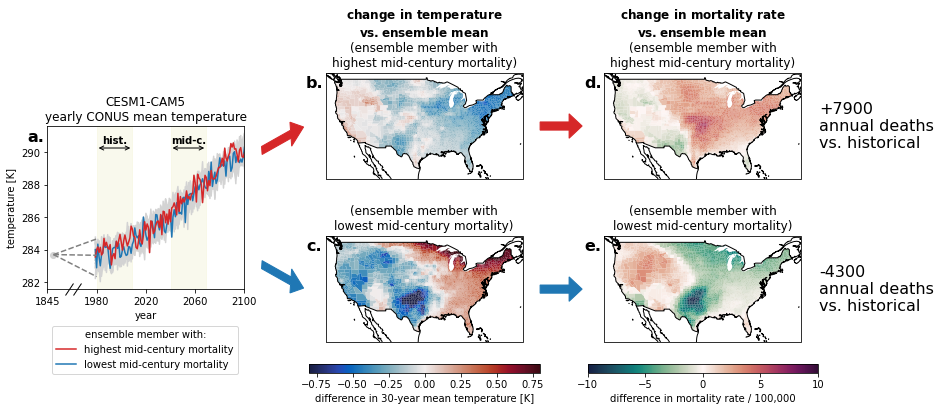

In [9]:
wrapper_figure2(master_params,data_counties,save_fig=True,output_fn=dir_list['figs']+'figure2')

### Figure 3

/home/kschwarz/projects/iv_impacts/figures/figure3.png saved!
/home/kschwarz/projects/iv_impacts/figures/figure3.svg saved!
/home/kschwarz/projects/iv_impacts/figures/figure3.pdf saved!


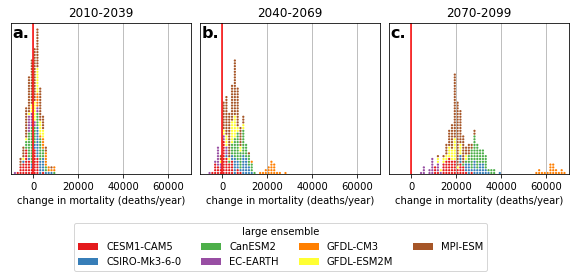

In [11]:
wrapper_figure3(master_params,subset_params,save_fig=True,fn=dir_list['figs']+'figure3')

### Figure 4

/home/kschwarz/projects/iv_impacts/figures/figure_4.png saved!
/home/kschwarz/projects/iv_impacts/figures/figure_4.pdf saved!


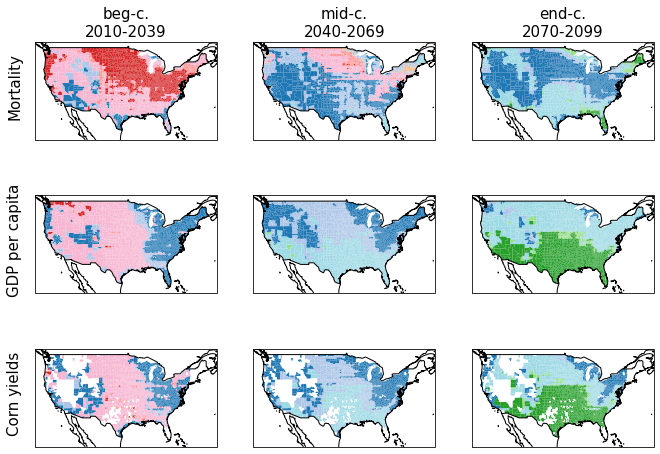

In [12]:
wrapper_figure4(master_params,data_counties,
                save_fig=True,output_fn=dir_list['figs']+'figure_4')

### Figure S1

/home/kschwarz/projects/iv_impacts/figures/figure_s1.png saved!
/home/kschwarz/projects/iv_impacts/figures/figure_s1.svg saved!


(<AxesSubplot:title={'center':'Variance in CONUS mean temperature'}, ylabel='fractional contribution to total uncertainty'>,
 [<BarContainer object of 3 artists>,
  <BarContainer object of 3 artists>,
  <BarContainer object of 3 artists>])

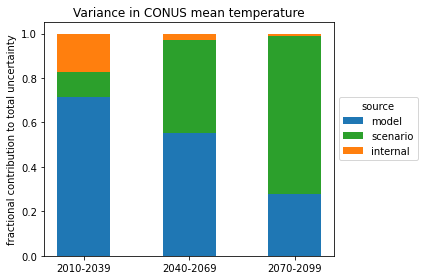

In [10]:
figure_part_uncert(master_params,'dtasmean','Variance in CONUS mean temperature',
                   fn_load = dir_list['proc']+master_params['obs_mod']+'/var_partitioning_all.nc',
                   save_fig=True,output_fn=dir_list['figs']+'figure_s1')

### Figure S2

/home/kschwarz/projects/iv_impacts/figures/figure_s2.png saved!
/home/kschwarz/projects/iv_impacts/figures/figure_s2.pdf saved!


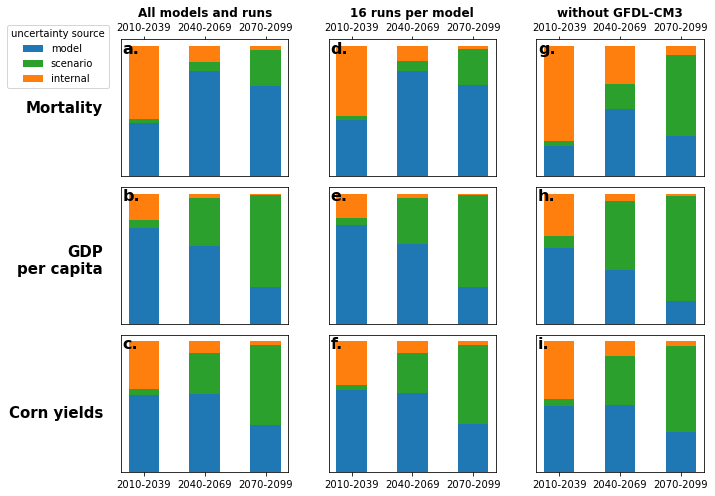

In [11]:
figure_partitioned_uncert_panel_bysource(master_params,output_fn=dir_list['figs']+'figure_s2')

### Figure S3

/home/kschwarz/projects/iv_impacts/figures/figure_s3.png saved!
/home/kschwarz/projects/iv_impacts/figures/figure_s3.pdf saved!


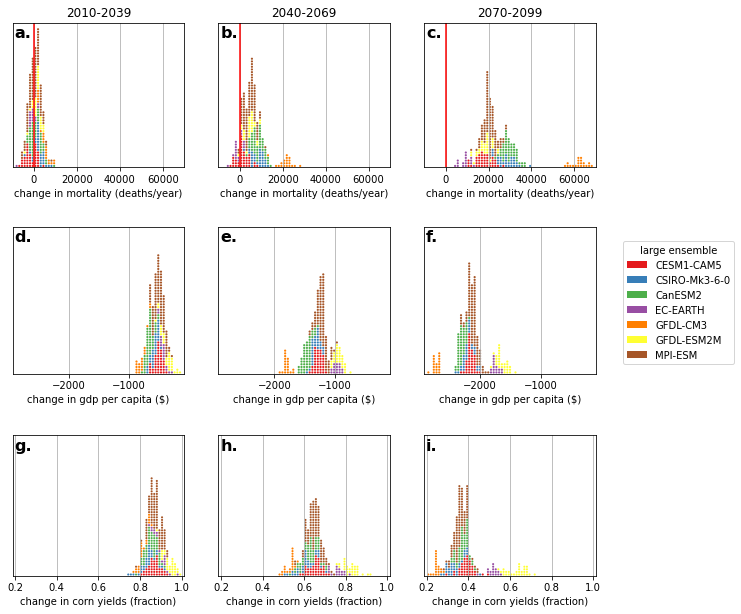

In [12]:
figure_bauble_panel(master_params,subset_params,save_fig=True,
                    output_fn=dir_list['figs']+'figure_s3',
                    binwidths=[1250,45,0.0125])

### Figure S4

/home/kschwarz/projects/iv_impacts/figures/figure_s4.png saved!
/home/kschwarz/projects/iv_impacts/figures/figure_s4.pdf saved!


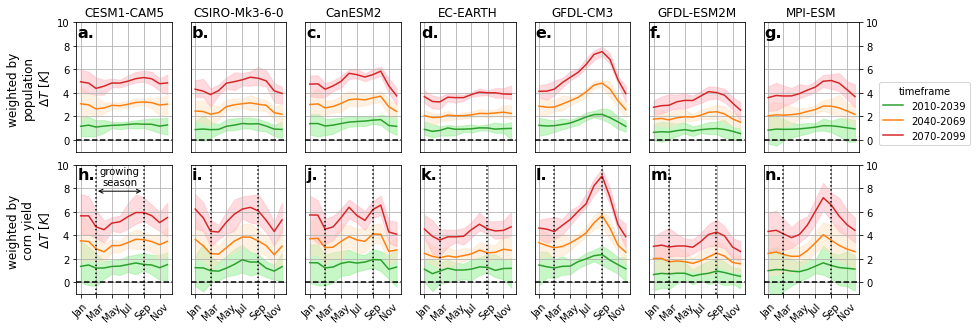

In [13]:
wrapper_figure_s4(master_params,subset_params,save_fig=True,fn=dir_list['figs']+'figure_s4')

### Figure S5

/home/kschwarz/projects/iv_impacts/figures/figure_s5.png saved!
/home/kschwarz/projects/iv_impacts/figures/figure_s5.pdf saved!


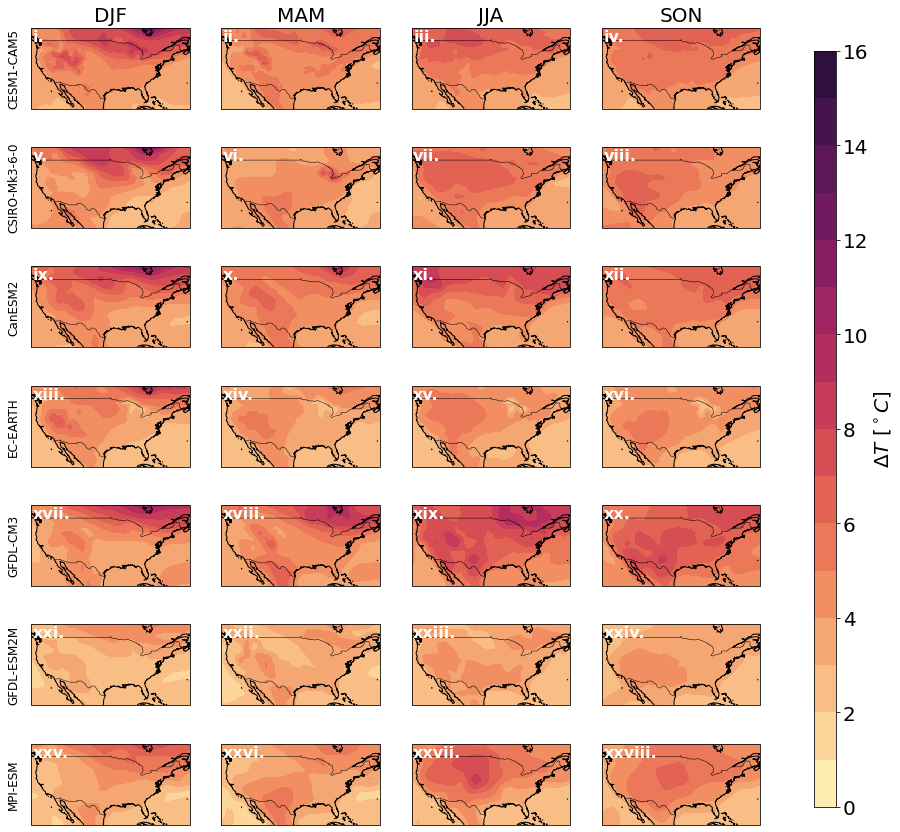

In [10]:
wrapper_figure_s5(master_params,subset_params,save_fig=True,output_fn=dir_list['figs']+'figure_s5')

### Figure S6

/home/kschwarz/projects/iv_impacts/figures/figure6.png saved!
/home/kschwarz/projects/iv_impacts/figures/figure6.pdf saved!


(<Figure size 720x432 with 10 Axes>,
 array([[<GeoAxesSubplot:title={'center':'2010-2039'}>,
         <GeoAxesSubplot:title={'center':'2040-2069'}>,
         <GeoAxesSubplot:title={'center':'2070-2099'}>],
        [<GeoAxesSubplot:>, <GeoAxesSubplot:>, <GeoAxesSubplot:>],
        [<GeoAxesSubplot:>, <GeoAxesSubplot:>, <GeoAxesSubplot:>]],
       dtype=object))

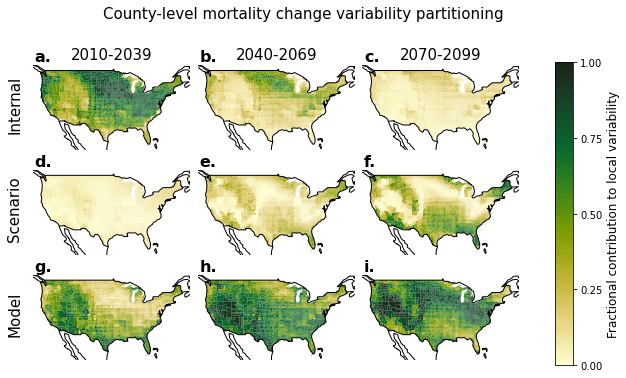

In [10]:
fig_geo_partition('dmort',data_counties,master_params,
                  save_fig=True,output_fn=dir_list['figs']+'figure_s6',
                  title='County-level mortality change variability partitioning')

### Figure S7

/home/kschwarz/projects/iv_impacts/figures/figure_s7.png saved!
/home/kschwarz/projects/iv_impacts/figures/figure_s7.pdf saved!


(<Figure size 720x432 with 10 Axes>,
 array([[<GeoAxesSubplot:title={'center':'2010-2039'}>,
         <GeoAxesSubplot:title={'center':'2040-2069'}>,
         <GeoAxesSubplot:title={'center':'2070-2099'}>],
        [<GeoAxesSubplot:>, <GeoAxesSubplot:>, <GeoAxesSubplot:>],
        [<GeoAxesSubplot:>, <GeoAxesSubplot:>, <GeoAxesSubplot:>]],
       dtype=object))

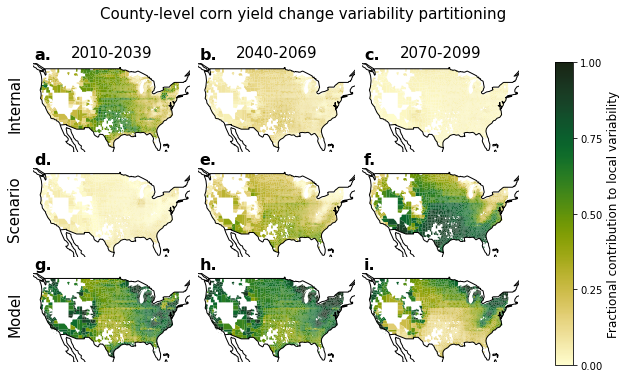

In [11]:
fig_geo_partition('dyield_tot',data_counties,master_params,
                  save_fig=True,output_fn=dir_list['figs']+'figure_s7',
                  title='County-level corn yield change variability partitioning')

### Figure S8

/home/kschwarz/projects/iv_impacts/figures/figure_s8.png saved!
/home/kschwarz/projects/iv_impacts/figures/figure_s8.pdf saved!


(<Figure size 720x432 with 10 Axes>,
 array([[<GeoAxesSubplot:title={'center':'2010-2039'}>,
         <GeoAxesSubplot:title={'center':'2040-2069'}>,
         <GeoAxesSubplot:title={'center':'2070-2099'}>],
        [<GeoAxesSubplot:>, <GeoAxesSubplot:>, <GeoAxesSubplot:>],
        [<GeoAxesSubplot:>, <GeoAxesSubplot:>, <GeoAxesSubplot:>]],
       dtype=object))

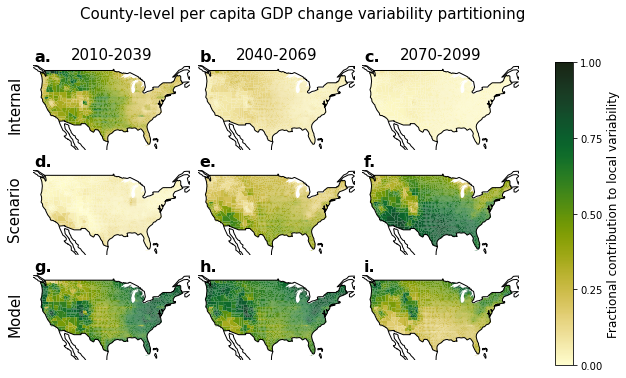

In [12]:
fig_geo_partition('dgdp-pp',data_counties,master_params,
                  save_fig=True,output_fn=dir_list['figs']+'figure_s8',
                  title='County-level per capita GDP change variability partitioning')

### Figure S9

/home/kschwarz/projects/iv_impacts/figures/figure_s7_0.png saved!
/home/kschwarz/projects/iv_impacts/figures/figure_s7_0.pdf saved!
/home/kschwarz/projects/iv_impacts/figures/figure_s7_1.png saved!
/home/kschwarz/projects/iv_impacts/figures/figure_s7_1.pdf saved!


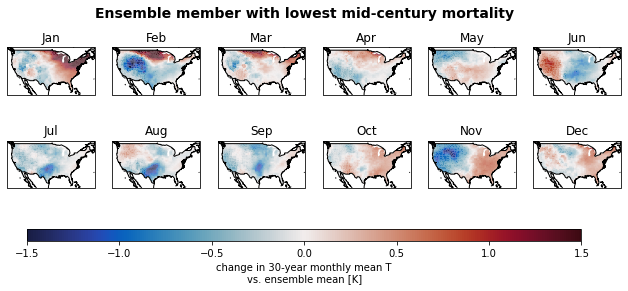

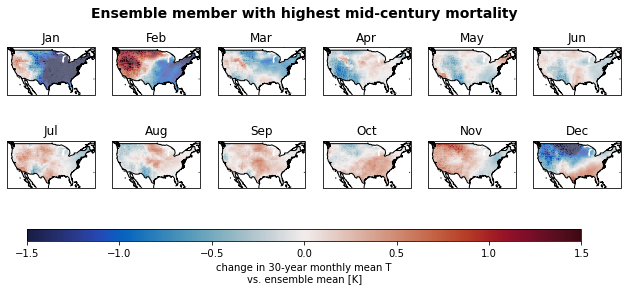

In [9]:
wrapper_dT_bymonth_maps(master_params,mod='CESM1-CAM5-LE',data_counties=data_counties,save_fig=True,
                        output_fn=dir_list['figs']+'figure_s9_')